In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
import pickle
from scipy.linalg import norm
from scipy.special import iv
from scipy.stats import beta
from tqdm.notebook import tqdm 

In [55]:
beta.rvs(10, 10, size=10) - 1/2

array([ 0.09866416, -0.04442639, -0.1439286 ,  0.09230213, -0.01416403,
       -0.01835161, -0.06439195, -0.0155118 ,  0.04572333, -0.16847991])

In [95]:
np.log(np.exp(1))

1.0

In [161]:
def A(d, kappa): 
    return iv(d/2, kappa) / iv(d/2-1, kappa)

def gen_beta1_vec(d): 
    return (beta.rvs(10, 10, size=d)-1/2) / (4*d)

def var_beta_vec(d): 
    
    var_single = 100 / ((20)**2 * (21)) / (4 * d)**2
    var_all = d * var_single 
    return var_all 

def psiE(x):
    assert 0 < x < 1
    return -x - np.log(1 - x)

def lambd(i, alpha, sigma2, n): 
    
    c = opt_c(alpha)
    #c = 2
    top =  c * np.log(1/alpha)
    bottom = n * sigma2 
    return min(np.sqrt(top / bottom), 0.5)

def opt_c(alpha): 
    return 2 + 8/(3*np.log(1/alpha))
    # return 8 + 32/(3 * np.log(1/alpha))

def zeta(alpha): 
    
    c = opt_c(alpha)
    return np.sqrt(9/2 + 6/np.log(1/alpha))
    return  3*np.sqrt(c) / 4 + 2 / (np.sqrt(c) * np.log(1/alpha)) + 3/(2 * np.sqrt(c))
    #return  3*np.sqrt(c) / 16 + 2 / (np.sqrt(c) * np.log(1/alpha)) + 3/(2 * np.sqrt(c))

def emp_bernstein(alpha, B, d, iters, gen_vec): 

    adk = A(d, np.sqrt(d))
    
    emp_mean_numerator = 1/2
    running_numerator = 4*B*np.sqrt(d)*adk + 2*B*np.log(1/alpha)
#    running_numerator = np.log(2/alpha)
    running_denominator = 0

    sigma_hat_top = 1/4

    width = []
    
    for i in range(1,int(iters)): 

        # Compute lambda 
        lmd = lambd(i, alpha, sigma_hat_top/i, iters)

        # Get observations 
        newX = gen_vec(d)

        # Update width 
        running_numerator += (psiE(lmd) / (2*B)) * (norm(newX - emp_mean_numerator / i))**2
        running_denominator += adk*lmd
        
        width.append(min(running_numerator/running_denominator, 1))
        
        # Update sigma and empirical mean 
        emp_mean_numerator += newX 
        sigma_hat_top += norm(newX - (emp_mean_numerator / (i+1)))**2
        
    return width 


def terms(alpha, B, d, iters, gen_vec): 
    

    emp_mean_numerator = 1/2
    sigma_hat_top = 1/4

    t2, t3 = 0, 0
    
    for i in range(1,int(iters)): 

        # Compute lambda 
        lmd = lambd(i, alpha, sigma_hat_top/i, iters)
        t3 += lmd

        # Get observations 
        newX = gen_vec(d)

        # Update width 
        t2 += psiE(lmd) * (norm(newX - emp_mean_numerator / i))**2
        
        
        # Update sigma and empirical mean 
        emp_mean_numerator += newX 
        sigma_hat_top += norm(newX - (emp_mean_numerator / (i+1)))**2
        
    t1 = sigma_hat_top / int(iters)
    t3 = t3 / np.sqrt(int(iters))
    return t1, t2, t3    
    


[  50000.  600000. 1150000. 1700000. 2250000. 2800000. 3350000. 3900000.
 4450000. 5000000.]



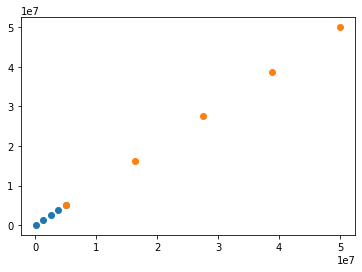

In [173]:
print(np.linspace(5*10e3, 5*10e5, 10))
print()


plt.plot(np.linspace(5*10e3, 5*10e5, 5), np.linspace(5*10e3, 5*10e5, 5), 'o')
plt.plot(np.linspace(5*10e5, 5*10e6, 5), np.linspace(5*10e5, 5*10e6, 5), 'o')

In [175]:
d = 2 
alpha = 0.01 
widths = []
for n in tqdm(np.linspace(5*10e4, 5*10e5, 5)[:-1]): 
    width = emp_bernstein(alpha, 1/2, d, n, gen_beta1_vec)
    widths.append(width[-1])


  0%|          | 0/4 [00:00<?, ?it/s]

In [120]:
def multiplier(alpha): 
    
    c = opt_c(alpha)
    
    adk = A(d, np.sqrt(d))
    la = np.log(1/alpha)
    
    x1 = np.sqrt(np.sqrt(c) * la) / (8 * adk)
    x2 = 2 * np.sqrt(d) / np.sqrt(c * la)
    x3 = np.sqrt(la) / (adk * np.sqrt(c))
    
    return x1 + x2 + x3

In [176]:
with open('widths_510e4_510e5.p', 'wb') as f: 
    pickle.dump(widths, f)

In [137]:
min(np.sqrt(ns) * np.array(widths))/asymp_width_eb

2.337513229354232

In [138]:
big_width = emp_bernstein(alpha, 1/2, d, 10e7, gen_beta1_vec)

In [142]:
big_width[-1] * np.sqrt(10e7) / asymp_width_eb

2.3185655946813055

In [164]:
zeta(alpha)

0.01

In [178]:
np.sqrt(ns) * np.array(widths)

array([0.13048925, 0.12465061, 0.12311729, 0.12236382])

Text(0.5, 0, 'Sample size')

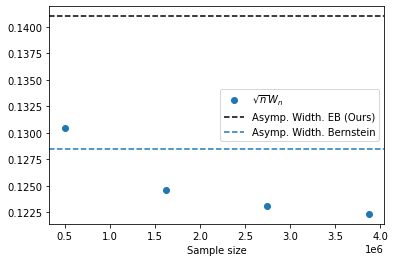

In [179]:
ns = np.linspace(5*10e4, 5*10e5, 5)[:-1]
plt.plot(ns, np.sqrt(ns) * np.array(widths), 'o', label='$\sqrt{n} W_n$')


asymp_width_eb = zeta(alpha) * np.sqrt(var_beta_vec(d) * d * np.log(1/alpha))
plt.axhline(asymp_width_eb, color='k', ls='--', label='Asymp. Width. EB (Ours)')
asymp_width_bern = np.sqrt(var_beta_vec(d) * 8*(np.log(2/alpha) + 1/4))
plt.axhline(y=asymp_width_bern, label='Asymp. Width. Bernstein', ls='--')
plt.legend()
plt.xlabel('Sample size')

In [117]:
d = 2
alpha = 0.01
t1, t2, t3 = [], [], []
for n in tqdm(np.linspace(5*10e4, 5*10e5, 5)): 
    res1, res2, res3 = terms(alpha, 1/2, d, n, gen_beta1_vec)
    t1.append(res1)
    t2.append(res2)
    t3.append(res3)

  0%|          | 0/5 [00:00<?, ?it/s]

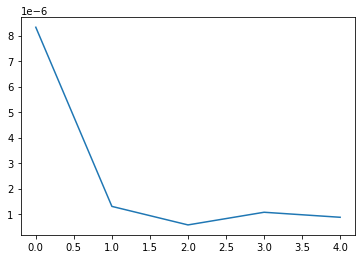

In [97]:


plt.plot(range(len(t1)), np.abs(np.array(t1) - var_beta_vec(d)))
# plt.axhline(var_beta_vec(d))

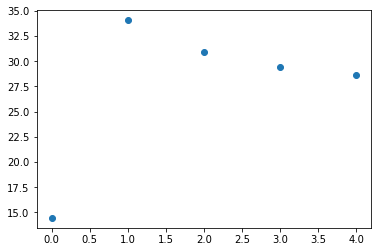

In [98]:
plt.plot(range(len(t2)), t2, 'o')
# plt.axhline(opt_c(alpha)/8 * np.log(1/alpha))
#plt.axhline(np.log(2/alpha))

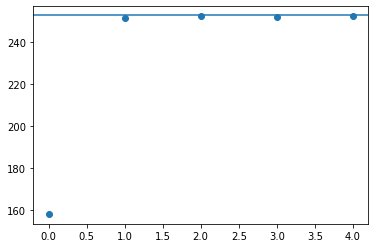

In [99]:
plt.plot(range(len(t3)), t3, 'o')
plt.axhline(np.sqrt(opt_c(alpha) * np.log(1/alpha) / var_beta_vec(d)))

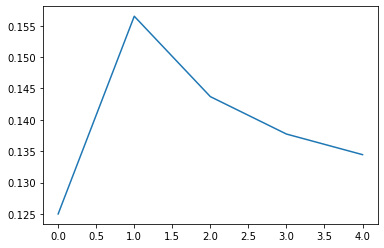

In [100]:
w = [(np.log(2/alpha) + x)/y for x, y in zip(t2, t3)]
plt.plot(range(len(w)), w)

In [7]:
widths = []
for n in tqdm(np.linspace(10e4 + 100000, 10e5, 9)): 
    res = emp_bernstein(alpha, 1/2, d, n, gen_beta1_vec)
    widths.append(res[-1])
    

  0%|          | 0/9 [00:00<?, ?it/s]

In [82]:
with open('widths_1000_10e4_1000.p', 'wb') as f: 
    pickle.dump(widths, f)

In [9]:
with open('widths_10e4_10e5_100000.p', 'wb') as f: 
    pickle.dump(widths, f)

In [3]:
with open('widths_10e4_10e5_100000.p', 'rb') as f: 
    widths = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'widths_10e4_10e5_100000.p'

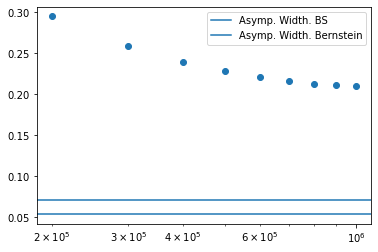

In [8]:
# ns = np.linspace(1000, 10e4, int(10e4/1000))# np.arange(len(widths)) * 1000
ns = np.linspace(10e4 + 100000, 10e5, 9)
plt.plot(ns, np.array(widths) * np.sqrt(ns), 'o')
asymp_width_bs =  zeta(alpha) * np.sqrt(var_beta_vec(d) * d * np.log(1/alpha))
plt.axhline(y=asymp_width_bs, label='Asymp. Width. BS')
asymp_width_bern = np.sqrt(var_beta_vec(d) * 8*(np.log(1/alpha) + 1/4))
plt.axhline(y=asymp_width_bern, label='Asymp. Width. Bernstein')
plt.xscale('log')
plt.legend()

In [6]:
d = 10
alpha = 0.01
# width_bs = emp_bernstein(alpha, 1/2, d, 10e5, gen_beta1_vec)

In [59]:
zeta(alpha)

0.665376593037442

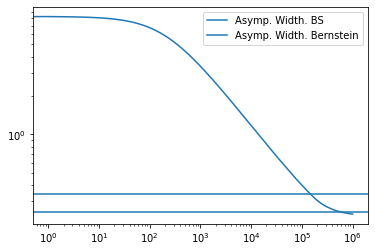

In [60]:
nwidth_bs = np.sqrt(np.arange(1, len(width_bs)+1)) * np.array(width_bs)
nwidth_bs = nwidth_bs[200:] # First 200 points are gross 
plt.plot(range(len(nwidth_bs)), nwidth_bs)


asymp_width_bs =  zeta(alpha) * np.sqrt(var_beta_vec(d) * d * np.log(1/alpha))
plt.axhline(y=asymp_width_bs, label='Asymp. Width. BS')
asymp_width_bern = np.sqrt(var_beta_vec(d) * 8*(np.log(1/alpha) + 1/4))
plt.axhline(y=asymp_width_bern, label='Asymp. Width. Bernstein')
plt.xscale('log')
plt.yscale('log')


plt.legend()